# TensorFlow Regression Example

## Creating Data


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Creating Data
x_data = np.linspace(0,10,1000000)

In [3]:
noise = np.random.randn(len(x_data))

In [5]:
b = 5
y_true = (0.5*x_data) + 5 + noise

In [6]:
my_data = pd.concat([pd.DataFrame(data=x_data,columns=['X Data']),pd.DataFrame(data=y_true,columns=['Y'])],axis=1)

In [8]:
my_data.head()

,X Data,Y
0,0.00000,3.040850
1,0.00001,4.725827
2,0.00002,3.839288
3,0.00003,5.830826
4,0.00004,4.740798


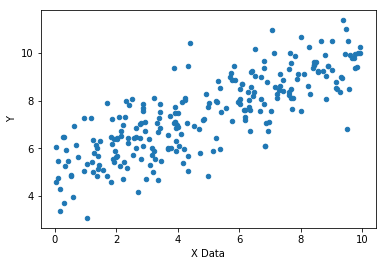

In [9]:
my_data.sample(n=250).plot(kind='scatter',x='X Data',y='Y')

# TensorFlow
## Batch Size

We will take the data in batches (1,000,000 points is a lot to pass in at once)

In [10]:
import tensorflow as tf
batch_size = 8

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [11]:
# Variables
m = tf.Variable(0.5)
b = tf.Variable(1.0)

In [12]:
# Placeholders
x_ph = tf.placeholder(tf.float32,[batch_size])
y_ph = tf.placeholder(tf.float32,[batch_size])

In [13]:
# Graph
y_model = m*x_ph + b

In [14]:
# Loss Function
error = tf.reduce_sum(tf.square(y_ph - y_model))

In [15]:
# Optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.001)
train = optimizer.minimize(error)

In [16]:
# Initialize Variables
init = tf.global_variables_initializer()

In [18]:
# Session
with tf.Session() as sess:
    sess.run(init)
    batches = 1000
    
    for i in range(batches):
        rand_ind = np.random.randint(len(x_data),size=batch_size)
        feed = {x_ph:x_data[rand_ind],y_ph:y_true[rand_ind]}
        sess.run(train,feed_dict=feed)
        
    model_m, model_b = sess.run([m,b])

In [19]:
model_m

0.5326854

In [20]:
model_b

4.9441442

In [21]:
# Results
y_hat = x_data * model_m + model_b

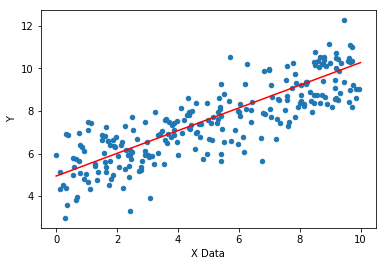

In [23]:
my_data.sample(n=250).plot(kind='scatter',x='X Data',y='Y')
plt.plot(x_data,y_hat,'r')

## tf.estimator API

Much simpler API for basic tasks like regression!

In [24]:
feat_cols = [tf.feature_column.numeric_column('x',shape=[1])]

In [26]:
estimator = tf.estimator.LinearRegressor(feature_columns=feat_cols)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/sg/0yd_0m2s28l4yzc10h42qff80000gn/T/tmpigabyxix', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x183caaf860>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Train Test Split

We haven't actually performed a train test split yet! So let's do that on our data now and perform a more realistic version of a Regression Task

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
x_train,x_eval,y_train,y_eval = train_test_split(x_data,y_true,test_size=0.2,random_state=1)

In [29]:
print(x_train.shape)
print(y_train.shape)

print(x_eval.shape)
print(y_eval.shape)

(800000,)
(800000,)
(200000,)
(200000,)


### Set up Estimator Inputs

In [30]:
input_func = tf.estimator.inputs.numpy_input_fn({'x':x_train},y_train,batch_size=4,num_epochs=None,shuffle=True)

In [31]:
train_input_func = tf.estimator.inputs.numpy_input_fn({'x':x_train},y_train,batch_size=4,num_epochs=1000,shuffle=False)

In [32]:
eval_input_func = tf.estimator.inputs.numpy_input_fn({'x':x_eval},y_eval,batch_size=4,num_epochs=1000,shuffle=False)

### Train the Estimator


In [33]:
estimator.train(input_fn=input_func,steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/sg/0yd_0m2s28l4yzc10h42qff80000gn/T/tmpigabyxix/model.ckpt.
INFO:tensorflow:loss = 276.9148, step = 1
INFO:tensorflow:global_step/sec: 144.028
INFO:tensorflow:loss = 29.818888, step = 101 (0.699 sec)
INFO:tensorflow:global_step/sec: 346.983
INFO:tensorflow:loss = 8.499544, step = 201 (0.286 sec)
INFO:tensorflow:global_step/sec: 273.494
INFO:tensorflow:loss = 10.049524, step = 301 (0.364 sec)
INFO:tensorflow:global_step/sec: 422.633
INFO:tensorflow:loss = 5.2304316, step = 401 (0.237 sec)
INFO:tensorflow:global_step/sec: 305.599
INFO:tensorflow:loss = 6.5005436, step = 501 (0.326 sec)
INFO:tensorflow:global_step/sec: 367.722
INFO:tensorflow:loss = 11.781179, step = 601 (0.272 sec)
INFO:tensorflow

### Evaluation

In [36]:
train_metrics = estimator.evaluate(input_fn=train_input_func,steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-19-16:28:00
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/sg/0yd_0m2s28l4yzc10h42qff80000gn/T/tmpigabyxix/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [100/1000]
INFO:tensorflow:Evaluation [200/1000]
INFO:tensorflow:Evaluation [300/1000]
INFO:tensorflow:Evaluation [400/1000]
INFO:tensorflow:Evaluation [500/1000]
INFO:tensorflow:Evaluation [600/1000]
INFO:tensorflow:Evaluation [700/1000]
INFO:tensorflow:Evaluation [800/1000]
INFO:tensorflow:Evaluation [900/1000]
INFO:tensorflow:Evaluation [1000/1000]
INFO:tensorflow:Finished evaluation at 2018-11-19-16:28:02
INFO:tensorflow:Saving dict for global step 1000: average_loss = 1.1344806, global_step = 1000, label/mean = 7.520504, loss = 4.5379224, prediction/mean = 7.282381
INFO:tensorflow:Saving 'c

In [38]:
eval_metrics = estimator.evaluate(input_fn=eval_input_func,steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-19-16:28:23
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/sg/0yd_0m2s28l4yzc10h42qff80000gn/T/tmpigabyxix/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [100/1000]
INFO:tensorflow:Evaluation [200/1000]
INFO:tensorflow:Evaluation [300/1000]
INFO:tensorflow:Evaluation [400/1000]
INFO:tensorflow:Evaluation [500/1000]
INFO:tensorflow:Evaluation [600/1000]
INFO:tensorflow:Evaluation [700/1000]
INFO:tensorflow:Evaluation [800/1000]
INFO:tensorflow:Evaluation [900/1000]
INFO:tensorflow:Evaluation [1000/1000]
INFO:tensorflow:Finished evaluation at 2018-11-19-16:28:26
INFO:tensorflow:Saving dict for global step 1000: average_loss = 1.1395711, global_step = 1000, label/mean = 7.52247, loss = 4.5582843, prediction/mean = 7.281413
INFO:tensorflow:Saving 'ch

In [39]:
print("train metrics: {}".format(train_metrics))
print("eval metrics: {}".format(eval_metrics))

train metrics: {'average_loss': 1.1344806, 'label/mean': 7.520504, 'loss': 4.5379224, 'prediction/mean': 7.282381, 'global_step': 1000}
eval metrics: {'average_loss': 1.1395711, 'label/mean': 7.52247, 'loss': 4.5582843, 'prediction/mean': 7.281413, 'global_step': 1000}


### Predictions

In [40]:
input_fn_predict = tf.estimator.inputs.numpy_input_fn({'x':np.linspace(0,10,10)},shuffle=False)

In [41]:
list(estimator.predict(input_fn=input_fn_predict))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/sg/0yd_0m2s28l4yzc10h42qff80000gn/T/tmpigabyxix/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


[{'predictions': array([4.2741175], dtype=float32)},
 {'predictions': array([4.93595], dtype=float32)},
 {'predictions': array([5.597782], dtype=float32)},
 {'predictions': array([6.259615], dtype=float32)},
 {'predictions': array([6.9214473], dtype=float32)},
 {'predictions': array([7.5832796], dtype=float32)},
 {'predictions': array([8.245111], dtype=float32)},
 {'predictions': array([8.906944], dtype=float32)},
 {'predictions': array([9.568777], dtype=float32)},
 {'predictions': array([10.23061], dtype=float32)}]

In [42]:
predictions = []# np.array([])
for x in estimator.predict(input_fn=input_fn_predict):
    predictions.append(x['predictions'])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/sg/0yd_0m2s28l4yzc10h42qff80000gn/T/tmpigabyxix/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [43]:
predictions

[array([4.2741175], dtype=float32),
 array([4.93595], dtype=float32),
 array([5.597782], dtype=float32),
 array([6.259615], dtype=float32),
 array([6.9214473], dtype=float32),
 array([7.5832796], dtype=float32),
 array([8.245111], dtype=float32),
 array([8.906944], dtype=float32),
 array([9.568777], dtype=float32),
 array([10.23061], dtype=float32)]

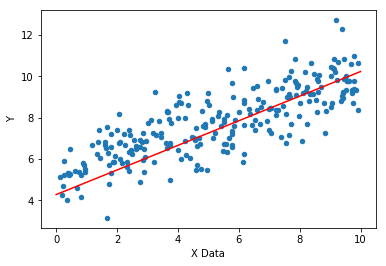

In [44]:
my_data.sample(n=250).plot(kind='scatter',x='X Data',y='Y')
plt.plot(np.linspace(0,10,10),predictions,'r')